## parameters

In [46]:
import numpy as np
import random
import csv
import time
import matplotlib.pyplot as plt

# bat algorithm parameters
num_bats = 30
max_iterations = 100
frequency_min = 0.0
frequency_max = 2.5
alpha = 0.95  # updated decay rate
gamma = 0.95 
initial_loudness = 1.0
initial_pulse_rate = 0.5
mutation_rate = 0.2  # added mutation rate

## fitness function

In [47]:
def fitness(data, position, label, dimensions):
    distances = []
    for row in data:
        if row['class'] == label:
            distance = np.sqrt(sum((row[dim] - position[d]) ** 2 for d, dim in enumerate(dimensions)))
            distances.append(distance)
    mean_distance = np.mean(distances)
    return mean_distance

#### Mean Distance Calculation: The fitness function now computes the mean distance instead of the sum of distances.

## Bat Algorithm function

In [48]:
def BatAlgorithm(data, label, dimensions, search_space, mutation_rate):
    # initialize bat positions randomly within search space
    positions = np.random.uniform(low=search_space[0], high=search_space[1], size=(num_bats, len(dimensions)))
    velocities = np.zeros_like(positions)
    frequencies = np.zeros(num_bats)
    loudness = np.full(num_bats, initial_loudness)
    pulse_rate = np.full(num_bats, initial_pulse_rate)
    
    # initialize global best position
    gbest_position = positions[np.argmin([fitness(data, pos, label, dimensions) for pos in positions])]
    gbest_fitness = fitness(data, gbest_position, label, dimensions)
    fitness_over_time = []
    positions_over_time = []
    gbest_position_history = []

    # main loop
    for iteration in range(max_iterations):
        for i in range(num_bats):
            frequencies[i] = frequency_min + (frequency_max - frequency_min) * random.random()
            velocities[i] += (positions[i] - gbest_position) * frequencies[i]
            positions[i] += velocities[i]
            
            #added random walk for increased diversity
            if random.random() > pulse_rate[i]:
                positions[i] = gbest_position + 0.05 * np.random.randn(len(dimensions))  # Enhanced random walk
            
            # ensure positions are in bounds; reinitialize if stuck at boundary
            positions[i] = np.clip(positions[i], search_space[0], search_space[1])
            reinit_probability = 0.1 * (1 - iteration / max_iterations)  # Dynamic reinitialization
            if random.random() < reinit_probability:
                positions[i] = np.random.uniform(low=search_space[0], high=search_space[1], size=len(dimensions))  # Reinitialization
            
            # added mutation
            if random.random() < mutation_rate:
                positions[i] += np.random.uniform(-5, 5, size=len(dimensions))  # Enhanced mutation step
                positions[i] = np.clip(positions[i], search_space[0], search_space[1])

            # evaluate fitness; update personal & global bests
            current_fitness = fitness(data, positions[i], label, dimensions)
            if current_fitness < gbest_fitness and loudness[i] > random.random():
                gbest_position = positions[i].copy()
                gbest_fitness = current_fitness
                loudness[i] *= alpha
                pulse_rate[i] *= (1 - np.exp(-gamma * iteration))
        
        fitness_over_time.append(gbest_fitness)
        positions_over_time.append(positions.copy())
        gbest_position_history.append(gbest_position.copy())
        
        # print statements to evaluate optimazation process  
        print(f"Iteration {iteration+1}/{max_iterations}")
        print(f"Best Fitness: {gbest_fitness}")
        print(f"Best Position: {gbest_position}")
        print(f"Positions:\n{positions}\n")
        
    return gbest_position, fitness_over_time, positions_over_time, gbest_position_history


## read the dataset

In [49]:
def read_dataset(filename):
    with open(filename, mode='r') as file:
        reader = csv.DictReader(file)
        data = []
        for row in reader:
            row_data = {key: float(value) if key != 'class' else value for key, value in row.items()}
            data.append(row_data)
        return data

## compute centroids for each class label

In [50]:
def compute_centroids(data, label, dimensions, search_space, mutation_rate):
    centroid, fitness_over_time, positions_over_time, gbest_position_history = BatAlgorithm(data, label, dimensions, search_space, mutation_rate)
    return centroid, fitness_over_time, positions_over_time, gbest_position_history

## Plots

In [51]:
def plot_gbest_position_history(centroids, dimensions):
    plt.figure(figsize=(10, 12))
    
    # plot feature 1
    plt.subplot(2, 1, 1)
    for label, (_, _, _, gbest_position_history) in centroids.items():
        gbest_positions = np.array(gbest_position_history)
        plt.plot(gbest_positions[:, 0], label=f'{label}', marker='x')
    plt.xlabel('Iterations')
    plt.ylabel(dimensions[0])
    plt.title(f'Global Best Position History for {dimensions[0]}')
    plt.legend(loc='upper right')
    plt.grid(True)
    
    # plot feature 2
    plt.subplot(2, 1, 2)
    for label, (_, _, _, gbest_position_history) in centroids.items():
        gbest_positions = np.array(gbest_position_history)
        plt.plot(gbest_positions[:, 1], label=f'{label}', marker='o')
    plt.xlabel('Iterations')
    plt.ylabel(dimensions[1])
    plt.title(f'Global Best Position History for {dimensions[1]}')
    plt.legend(loc='upper right')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

## main script 

In [52]:
start_time = time.time()
dataset = read_dataset('/Users/angelesmarin/Desktop/2C_2D_dataset.csv')
dimension_keys = [key for key in dataset[0].keys() if key != 'class']
search_space = (0, 100) 
labels = set(row['class'] for row in dataset)

centroids = {label: compute_centroids(dataset, label, dimension_keys, search_space, mutation_rate) for label in labels}

print("Final Centroids:")
for label, (centroid, _, _, _) in centroids.items():
    print(f"Label {label}: {centroid}")

print(f"Time taken (seconds): {time.time() - start_time}")


Iteration 1/100
Best Fitness: 14.346251414200069
Best Position: [84.02855849 79.1028618 ]
Positions:
[[  0.          57.1656411 ]
 [ 73.41465199  54.04949543]
 [ 70.87238393  55.77759117]
 [  8.08472035  53.73895487]
 [ 70.09162612  58.7866591 ]
 [ 18.73117355   1.26587745]
 [ 70.08764497  58.8381902 ]
 [ 88.51339392 100.        ]
 [ 66.89223351  63.53478994]
 [ 66.94370762  63.49581317]
 [ 67.00913045  63.5274557 ]
 [ 83.06422431  83.93836698]
 [  0.           0.        ]
 [ 54.65776757  18.54885116]
 [ 29.81243632  55.45505533]
 [ 83.05012449  83.88246929]
 [ 83.05413108  83.94604196]
 [ 83.06518682  83.85629317]
 [ 52.18844102  42.18177249]
 [ 85.97184927   2.72893552]
 [  0.         100.        ]
 [  0.           0.        ]
 [ 65.40851789 100.        ]
 [ 84.02855849  79.1028618 ]
 [ 18.14968128   0.        ]
 [ 86.1612844   97.44657474]
 [ 87.86913133  76.2437137 ]
 [ 82.80517902  17.87976911]
 [  0.           0.        ]
 [ 84.06451117  79.20337851]]

Iteration 2/100
Best Fitnes

## fitness function values over iterations

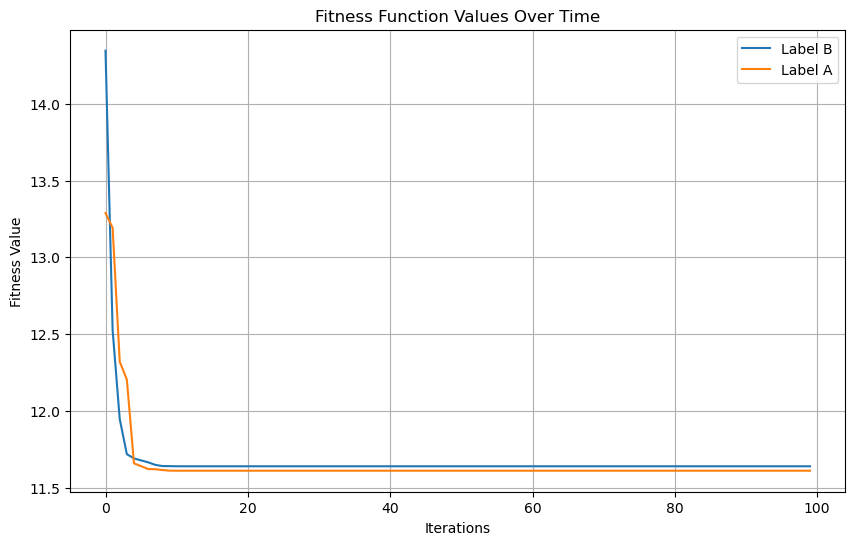

In [53]:
plt.figure(figsize=(10, 6))
for label, (_, fitness_over_time, _, _) in centroids.items():
    plt.plot(fitness_over_time, label=f'Label {label}')
plt.xlabel('Iterations')
plt.ylabel('Fitness Value')
plt.title('Fitness Function Values Over Time')
plt.legend()
plt.grid(True)
plt.show()

## global best position over iterations

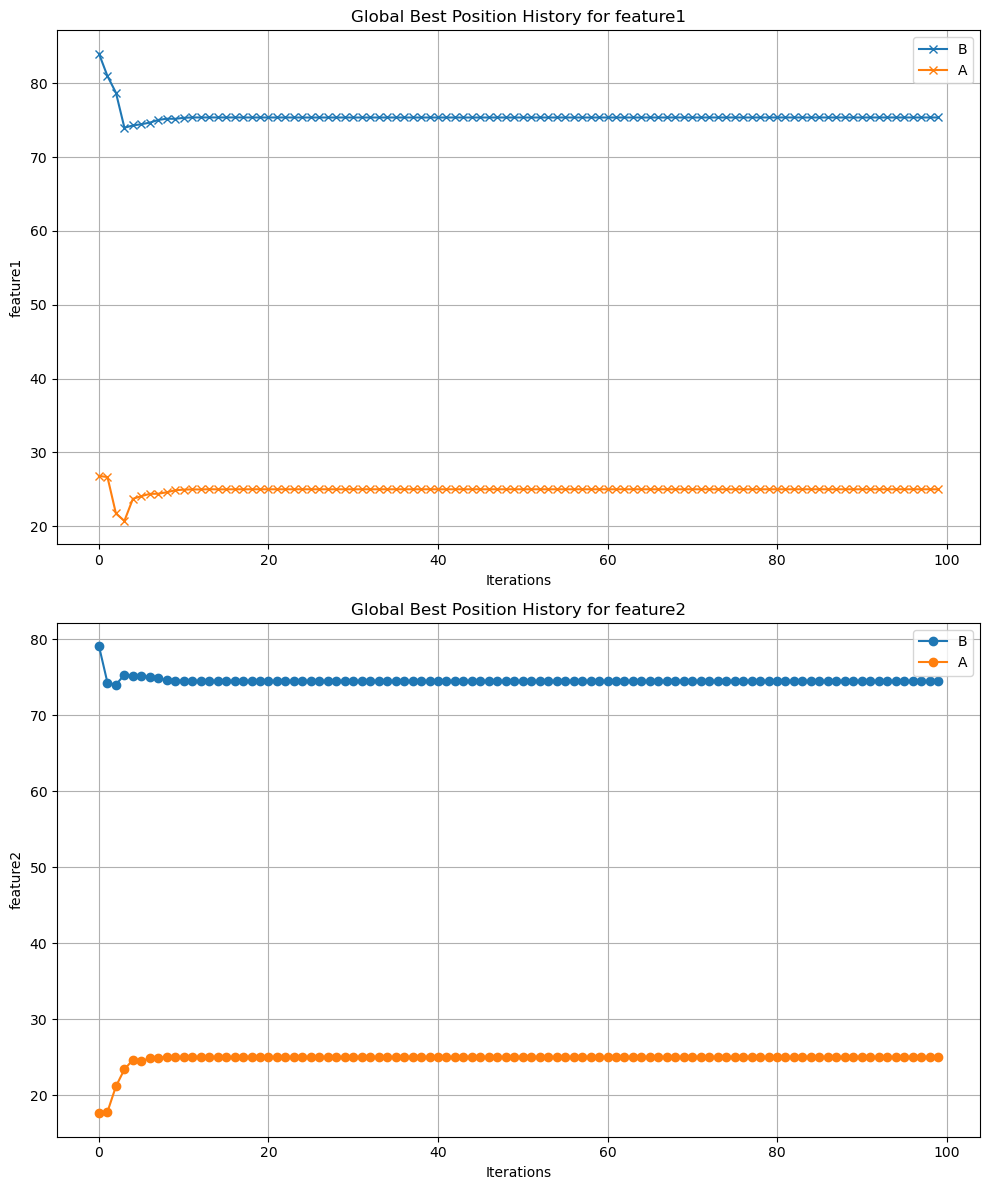

In [54]:
plot_gbest_position_history(centroids, dimension_keys)
